In [1]:
import numpy as np
import optuna
import sys
import joblib
import pandas as pd
import json
import matplotlib.pyplot as plt
import matplotlib
import lightgbm as lgb
import xgboost as xgb 
from sklearn.ensemble import RandomForestRegressor
import pickle

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

In [7]:
output_dir = '../../split_income_models'

### Loading Data

In [5]:
filepath = '../../split_income_data'

In [6]:
train = {}
for fold in range(0, 5):
    tdata_x85 = pd.read_csv(filepath + '/train/X_train_' + str(fold) + '_85.csv')
    tdata_x85 = tdata_x85.drop(columns=['Unnamed: 0'], axis=1)
    tdata_y85 = pd.read_csv(filepath + '/train/y_train_' + str(fold) + '_85.csv')
    tdata_y85 = tdata_y85.drop(columns=['Unnamed: 0'], axis=1)

    tdata_x95 = pd.read_csv(filepath + '/train/X_train_' + str(fold) + '_95.csv')
    tdata_x95 = tdata_x95.drop(columns=['Unnamed: 0'], axis=1)
    tdata_y95 = pd.read_csv(filepath + '/train/y_train_' + str(fold) + '_95.csv')
    tdata_y95 = tdata_y95.drop(columns=['Unnamed: 0'], axis=1)

    tdata_x1 = pd.read_csv(filepath + '/train/X_train_' + str(fold) + '_1.csv')
    tdata_x1 = tdata_x1.drop(columns=['Unnamed: 0'], axis=1)
    tdata_y1 = pd.read_csv(filepath + '/train/y_train_' + str(fold) + '_1.csv')
    tdata_y1 = tdata_y1.drop(columns=['Unnamed: 0'], axis=1)

    train[fold] = [tdata_x85, tdata_y85, tdata_x95, tdata_y95, tdata_x1, tdata_y1]

In [8]:
test_data_x = pd.read_csv(filepath + '/test/X_test.csv')
test_data_x = test_data_x.drop(columns=['Unnamed: 0'], axis=1)
test_data_y = pd.read_csv(filepath + '/test/y_test.csv')
test_data_y = test_data_y.drop(columns=['Unnamed: 0'], axis=1)

In [10]:
with open('../../split_income_models/countries_dict.pkl', 'rb') as f:
    countries_dict = pickle.load(f)

### Setting up Tables

In [11]:
# setting up the dataframe to hold test results
index_rows = pd.MultiIndex.from_tuples(
    [('Threshold 85%', '1'), ('Threshold 85%', '2'), ('Threshold 85%', '3'), ('Threshold 85%', '4'), ('Threshold 85%', '5'),
     ('Threshold 95%', '1'), ('Threshold 95%', '2'), ('Threshold 95%', '3'), ('Threshold 95%', '4'), ('Threshold 95%', '5'),
     ('None', '1'), ('None', '2'), ('None', '3'), ('None', '4'), ('None', '5')],
    names=['Missing Data Threshold', 'Fold']
)

index_cols = pd.MultiIndex.from_tuples(
    [('LightGBM', 'MAPE'), ('LightGBM', 'MAE'), ('LightGBM', 'MSE'), ('LightGBM', 'RMSE'), ('LightGBM', 'R2'), 
     ('XGBoost', 'MAPE'), ('XGBoost', 'MAE'), ('XGBoost', 'MSE'), ('XGBoost', 'RMSE'), ('XGBoost', 'R2'),
     ('Random Forest', 'MAPE'), ('Random Forest', 'MAE'), ('Random Forest', 'MSE'), ('Random Forest', 'RMSE'), ('Random Forest', 'R2')],
    names=['Model', 'Evaluation Metric']
)

test_stats = pd.DataFrame(index=index_rows, columns=index_cols)

test_stats

Model                       LightGBM                     XGBoost            \
Evaluation Metric               MAPE  MAE  MSE RMSE   R2    MAPE  MAE  MSE   
Missing Data Threshold Fold                                                  
Threshold 85%          1         NaN  NaN  NaN  NaN  NaN     NaN  NaN  NaN   
                       2         NaN  NaN  NaN  NaN  NaN     NaN  NaN  NaN   
                       3         NaN  NaN  NaN  NaN  NaN     NaN  NaN  NaN   
                       4         NaN  NaN  NaN  NaN  NaN     NaN  NaN  NaN   
                       5         NaN  NaN  NaN  NaN  NaN     NaN  NaN  NaN   
Threshold 95%          1         NaN  NaN  NaN  NaN  NaN     NaN  NaN  NaN   
                       2         NaN  NaN  NaN  NaN  NaN     NaN  NaN  NaN   
                       3         NaN  NaN  NaN  NaN  NaN     NaN  NaN  NaN   
                       4         NaN  NaN  NaN  NaN  NaN     NaN  NaN  NaN   
                       5         NaN  NaN  NaN  NaN  NaN     NaN  NaN  NaN   
None                   1         NaN  NaN  NaN  NaN  NaN     NaN  NaN  NaN   
                       2         NaN  NaN  NaN  NaN  NaN     NaN  NaN  NaN   
                       3         NaN  NaN  NaN  NaN  NaN     NaN  NaN  NaN   
                       4         NaN  NaN  NaN  NaN  NaN     NaN  NaN  NaN   
                       5         NaN  NaN  NaN  NaN  NaN     NaN  NaN  NaN   

Model                                 Random Forest                      
Evaluation Metric           RMSE   R2          MAPE  MAE  MSE RMSE   R2  
Missing Data Threshold Fold                                              
Threshold 85%          1     NaN  NaN           NaN  NaN  NaN  NaN  NaN  
                       2     NaN  NaN           NaN  NaN  NaN  NaN  NaN  
                       3     NaN  NaN           NaN  NaN  NaN  NaN  NaN  
                       4     NaN  NaN           NaN  NaN  NaN  NaN  NaN  
                       5     NaN  NaN           NaN  NaN  NaN  NaN  NaN  
Threshold 95%          1     NaN  NaN           NaN  NaN  NaN  NaN  NaN  
                       2     NaN  NaN           NaN  NaN  NaN  NaN  NaN  
                       3     NaN  NaN           NaN  NaN  NaN  NaN  NaN  
                       4     NaN  NaN           NaN  NaN  NaN  NaN  NaN  
                       5     NaN  NaN           NaN  NaN  NaN  NaN  NaN  
None                   1     NaN  NaN           NaN  NaN  NaN  NaN  NaN  
                       2     NaN  NaN           NaN  NaN  NaN  NaN  NaN  
                       3     NaN  NaN           NaN  NaN  NaN  NaN  NaN  
                       4     NaN  NaN           NaN  NaN  NaN  NaN  NaN  
                       5     NaN  NaN           NaN  NaN  NaN  NaN  NaN

### LightGBM

#### Data Collection

In [34]:
# setting up the dataframe to hold test results
rows_params = pd.MultiIndex.from_tuples(
    [('Threshold 85%', '1'), ('Threshold 85%', '2'), ('Threshold 85%', '3'), ('Threshold 85%', '4'), ('Threshold 85%', '5'),
     ('Threshold 95%', '1'), ('Threshold 95%', '2'), ('Threshold 95%', '3'), ('Threshold 95%', '4'), ('Threshold 95%', '5'),
     ('None', '1'), ('None', '2'), ('None', '3'), ('None', '4'), ('None', '5')],
    names=['Missing Data Threshold', 'Fold']
)

lgbm_params = pd.DataFrame(index=index_rows, columns=['number_trees', 'max_tree_depth', 'boosting_type', 
                                                     'bagging_fraction', 'bagging_freq', 'learning_rate',
                                                     'l1_norm', 'l2_norm'])

In [35]:
test_data_x['setting'] = test_data_x['setting'].astype("category")
testing_x = test_data_x.copy()
testing_x.columns = testing_x.columns.str.replace(r'[\"\[\]\{\}\\:,]', '', regex=True)

for fold, fold_num in enumerate(['1', '2', '3', '4', '5']):
    for thresh, thresh_name in enumerate(['Threshold 85%', 'Threshold 95%', 'None']):
        
        if thresh == 0:
            name = '85'
        elif thresh == 1:
            name = '95'
        else: name = '1'

        best_params = joblib.load(f"{output_dir}/lightgbm/best_params_{fold}_{name}.pkl")
        param_list = list(best_params.values())
        lgbm_params.loc[(thresh_name, fold_num)] = param_list
        best_model = joblib.load(f"{output_dir}/lightgbm/best_params_{fold}_{name}.pkl")

        train_input_data = train[fold][thresh * 2].copy()
        train_input_data['setting'] = train_input_data['setting'].astype("category")
        train_input_data.columns = train_input_data.columns.str.replace(r'[\"\[\]\{\}\\:,]', '', regex=True)

        train_label = train[fold][thresh * 2 + 1].copy()
        train_label.column = 'Maternal mortality ratio (national estimate per 100000 live births)'

        columns_needed = testing_x.columns.intersection(train_input_data.columns)
        to_test = testing_x[columns_needed].copy()

        loaded_model = lgb.LGBMRegressor(**best_params, verbosity = -1)
        train_load = loaded_model.fit(train_input_data, train_label)
        prediction = train_load.predict(to_test)
        mse = mean_squared_error(test_data_y, prediction)
        mae = mean_absolute_error(test_data_y, prediction)
        rmse = np.sqrt(mse)
        r2 = r2_score(test_data_y, prediction)

        #to calculate mape
        num_predictions = len(prediction)
        mape = 0
        for p in range(0, num_predictions):
            mape += np.abs(prediction[p] - test_data_y.iloc[p]) / np.maximum(np.abs(prediction[p]), np.abs(test_data_y.iloc[p]))
        mape = mape/num_predictions
        #mape = (1/num_predictions) * np.sum(np.abs(prediction - test_data_y) / np.max(np.abs(prediction), np.abs(test_data_y)))

        test_stats.loc[(thresh_name, fold_num), ('LightGBM', 'MSE')] = mse
        test_stats.loc[(thresh_name, fold_num), ('LightGBM', 'MAE')] = mae
        test_stats.loc[(thresh_name, fold_num), ('LightGBM', 'RMSE')] = rmse
        test_stats.loc[(thresh_name, fold_num), ('LightGBM', 'R2')] = r2
        test_stats.loc[(thresh_name, fold_num), ('LightGBM', 'MAPE')] = mape[0]
        

/var/folders/jd/0gmk2m5x1cl2hh0v_hsx43q40000gn/T/ipykernel_29843/2913240475.py:49: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  test_stats.loc[(thresh_name, fold_num), ('LightGBM', 'MAPE')] = mape[0]
/var/folders/jd/0gmk2m5x1cl2hh0v_hsx43q40000gn/T/ipykernel_29843/2913240475.py:49: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  test_stats.loc[(thresh_name, fold_num), ('LightGBM', 'MAPE')] = mape[0]
/var/folders/jd/0gmk2m5x1cl2hh0v_hsx43q40000gn/T/ipykernel_29843/2913240475.py:49: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as lab

#### Visualisations

In [36]:
lgbm_params

number_trees max_tree_depth boosting_type  \
Missing Data Threshold Fold                                             
Threshold 85%          1             119              4          dart   
                       2              35             17          dart   
                       3             124              9          dart   
                       4              63              3          dart   
                       5              62              5          dart   
Threshold 95%          1             128             17          dart   
                       2             155             23          gbdt   
                       3             285              6          gbdt   
                       4              19             19          dart   
                       5             167             19          dart   
None                   1             120              6          dart   
                       2              72             18          dart   
                       3             191              4          dart   
                       4             153              7          dart   
                       5             160             19          dart   

                            bagging_fraction bagging_freq learning_rate  \
Missing Data Threshold Fold                                               
Threshold 85%          1            0.237136            3      0.147704   
                       2             0.71952            8      0.104208   
                       3            0.893179            4      0.696931   
                       4              0.8616            0      0.816495   
                       5            0.410795           10      0.371533   
Threshold 95%          1             0.18803            2      0.152064   
                       2            0.159638            7       0.03221   
                       3             0.53489            7      0.066483   
                       4            0.460955            5      0.524897   
                       5             0.32474            1      0.283565   
None                   1             0.21629            7      0.152534   
                       2            0.542625            7       0.16472   
                       3            0.804639            5      0.480674   
                       4            0.173195            8      0.207714   
                       5            0.488736            5      0.334877   

                              l1_norm   l2_norm  
Missing Data Threshold Fold                      
Threshold 85%          1     0.000461  0.000889  
                       2     0.000582  0.000589  
                       3     0.000777  0.000775  
                       4      0.00057   0.00005  
                       5     0.000761  0.000057  
Threshold 95%          1     0.000286  0.000664  
                       2     0.000334  0.000104  
                       3     0.000015   0.00031  
                       4       0.0005  0.000591  
                       5     0.000384  0.000253  
None                   1     0.000567  0.000082  
                       2     0.000134  0.000028  
                       3     0.000211  0.000091  
                       4     0.000976  0.000392  
                       5     0.000923  0.000275

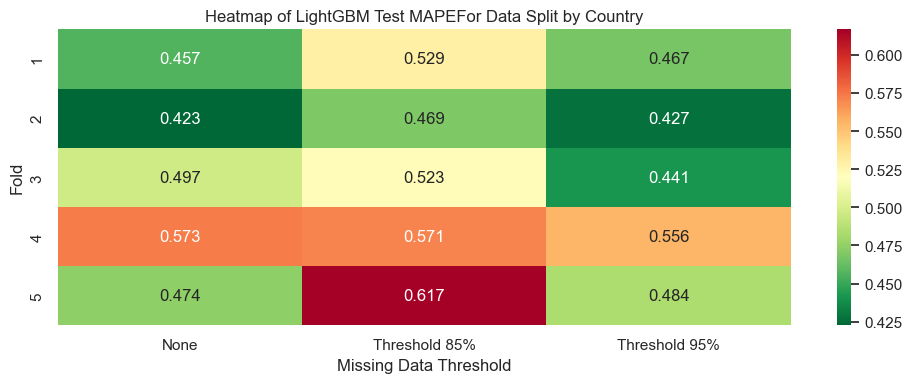

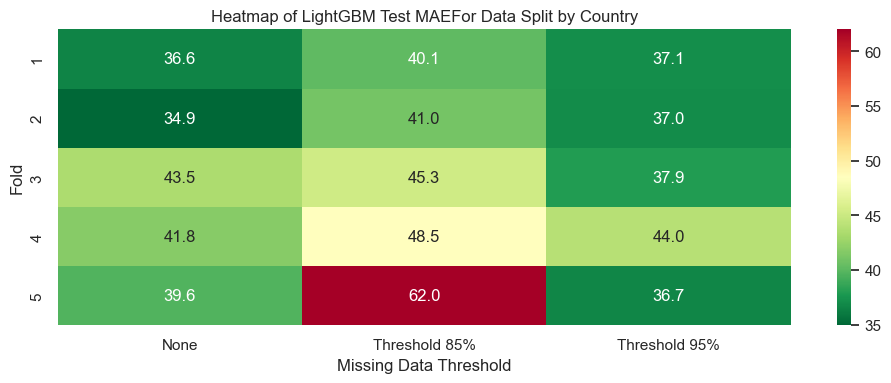

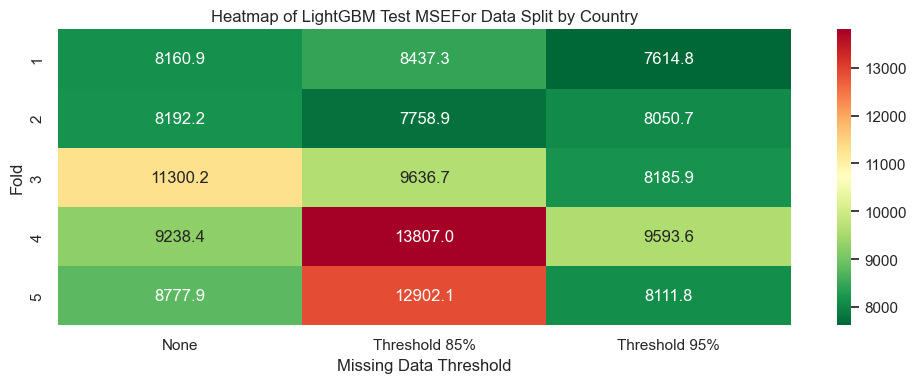

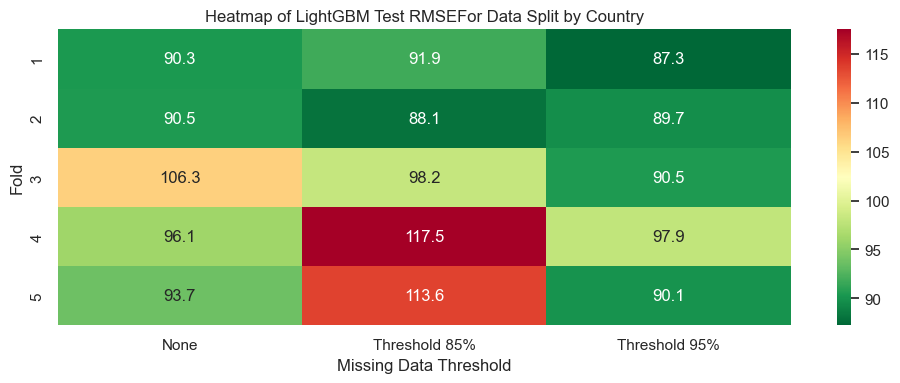

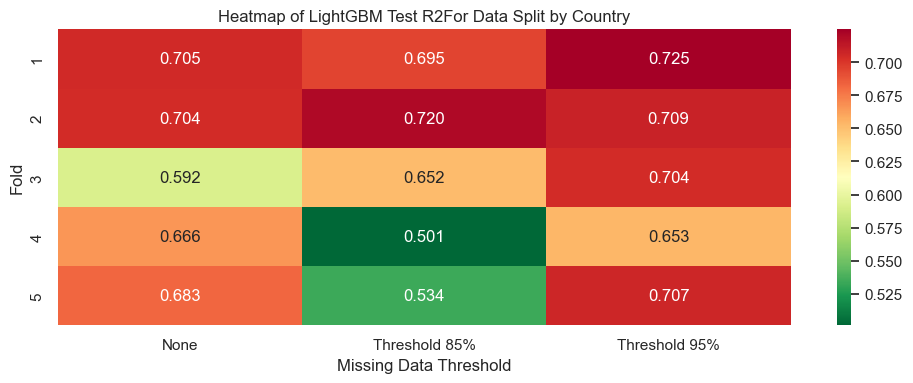

In [37]:
import seaborn as sns

data_lgbm = test_stats['LightGBM'].astype(float)

for metric in data_lgbm.columns:
    plt.figure(figsize=(10, 4))
    d = pd.DataFrame(data_lgbm[metric].unstack(level='Missing Data Threshold'))
    if metric == 'MAPE' or metric == 'R2':
        fmt = ".3f"
    else:
        fmt = ".1f"
    sns.heatmap(d, annot=True, fmt=fmt, cmap="RdYlGn_r", cbar=True)
    sns.set_theme(context='notebook', style='whitegrid')  # or 'paper'
    plt.title("Heatmap of LightGBM Test " + metric + "For Data Split by Country")
    plt.xlabel("Missing Data Threshold")
    plt.ylabel("Fold")
    plt.tight_layout()
    plt.show()

In [38]:
lgbm_data = test_stats['LightGBM'].astype(float)
mean_summary_lgbm = lgbm_data.groupby(level='Missing Data Threshold').mean()
mean_summary_lgbm = mean_summary_lgbm.astype('float')
mean_summary_lgbm = mean_summary_lgbm.round(2)
std_summary_lgbm = lgbm_data.groupby(level='Missing Data Threshold').std()
std_summary_lgbm = std_summary_lgbm.astype('float')
std_summary_lgbm = std_summary_lgbm.round(2)

In [39]:
mean_corr_lgbm = mean_summary_lgbm.corr()
mean_corr_lgbm

Evaluation Metric,MAPE,MAE,MSE,RMSE,R2
Evaluation Metric,,,,,
MAPE,1.000000,0.998380,0.969622,0.962277,-0.969455
MAE,0.998380,1.000000,0.954131,0.945235,-0.953927
MSE,0.969622,0.954131,1.000000,0.999596,-1.000000
RMSE,0.962277,0.945235,0.999596,1.000000,-0.999615
R2,-0.969455,-0.953927,-1.000000,-0.999615,1.000000


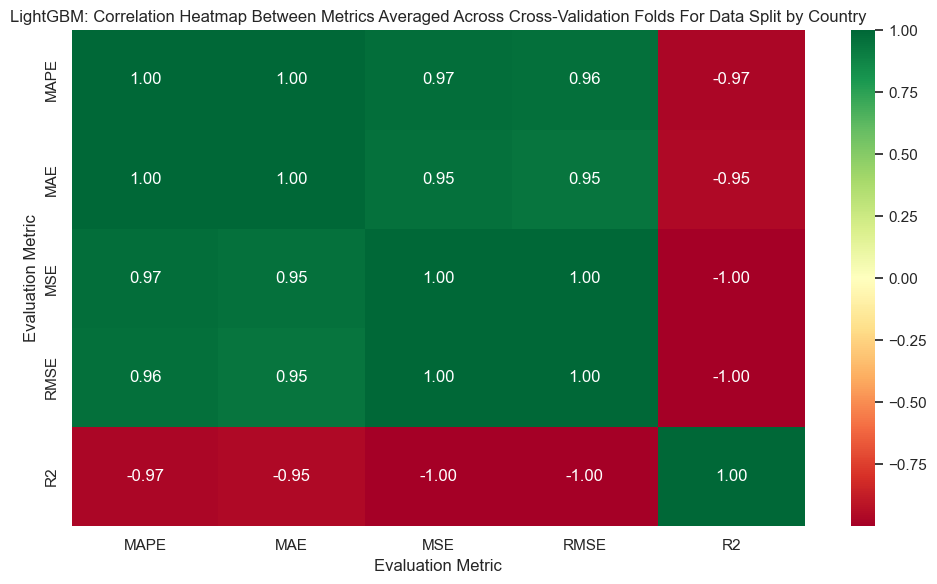

In [40]:
plt.figure(figsize=(10, 6))
sns.heatmap(mean_corr_lgbm, annot=True, fmt=".2f", cmap="RdYlGn", center=0)
plt.title("LightGBM: Correlation Heatmap Between Metrics Averaged Across Cross-Validation Folds For Data Split by Country")
plt.tight_layout()
plt.show()

### XGBoost

#### Data Collection

In [41]:
xgb_params = pd.DataFrame(index=index_rows, columns=['number_trees', 'max_tree_depth', 'boosting_type', 
                                                     'subsample', 'learning_rate','l1_norm', 'l2_norm'])

In [42]:
test_data_x['setting'] = test_data_x['setting'].astype("category")
testing_x = test_data_x.copy()

for fold, fold_num in enumerate(['1', '2', '3', '4', '5']):
    for thresh, thresh_name in enumerate(['Threshold 85%', 'Threshold 95%', 'None']):
        
        if thresh == 0:
            name = '85'
        elif thresh == 1:
            name = '95'
        else: name = '1'

        best_params = joblib.load(f"{output_dir}/xgboost/best_params_{fold}_{name}.pkl")
        param_list = list(best_params.values())
        xgb_params.loc[(thresh_name, fold_num)] = param_list

        train_input_data = train[fold][thresh * 2].copy()
        train_input_data['setting'] = train_input_data['setting'].astype("category")

        train_label = train[fold][thresh * 2 + 1].copy()

        columns_needed = testing_x.columns.intersection(train_input_data.columns)
        to_test = testing_x[columns_needed].copy()

        loaded_model = xgb.XGBRegressor(**best_params, enable_categorical=True)
        train_load = loaded_model.fit(train_input_data, train_label)
        prediction = train_load.predict(to_test)
        mse = mean_squared_error(test_data_y, prediction)
        mae = mean_absolute_error(test_data_y, prediction)
        rmse = np.sqrt(mse)
        r2 = r2_score(test_data_y, prediction)

        #to calculate mape
        num_predictions = len(prediction)
        mape = 0
        for p in range(0, num_predictions):
            mape += np.abs(prediction[p] - test_data_y.iloc[p]) / np.maximum(np.abs(prediction[p]), np.abs(test_data_y.iloc[p]))
        mape = mape/num_predictions
        #mape = (1/num_predictions) * np.sum(np.abs(prediction - test_data_y) / np.max(np.abs(prediction), np.abs(test_data_y)))

        test_stats.loc[(thresh_name, fold_num), ('XGBoost', 'MSE')] = mse
        test_stats.loc[(thresh_name, fold_num), ('XGBoost', 'MAE')] = mae
        test_stats.loc[(thresh_name, fold_num), ('XGBoost', 'RMSE')] = rmse
        test_stats.loc[(thresh_name, fold_num), ('XGBoost', 'R2')] = r2
        test_stats.loc[(thresh_name, fold_num), ('XGBoost', 'MAPE')] = mape[0]
        

/opt/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [12:58:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "boosting_type", "l1_norm", "l2_norm", "max_tree_depth", "number_trees" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/var/folders/jd/0gmk2m5x1cl2hh0v_hsx43q40000gn/T/ipykernel_29843/1823461600.py:45: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  test_stats.loc[(thresh_name, fold_num), ('XGBoost', 'MAPE')] = mape[0]
/opt/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [12:58:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "boosting_type", "l1_norm", "l2_norm", "max_tree_depth", "number_trees" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/v

#### Visualisations

In [43]:
xgb_params

number_trees max_tree_depth boosting_type  \
Missing Data Threshold Fold                                             
Threshold 85%          1              18              8        gbtree   
                       2              28             14          dart   
                       3              54             13          dart   
                       4             152             18          dart   
                       5             163             15          dart   
Threshold 95%          1             142              3        gbtree   
                       2              22             17          dart   
                       3              62              9          dart   
                       4              80             15        gbtree   
                       5              16             20          dart   
None                   1              18             22          dart   
                       2              72             10          dart   
                       3              42             20        gbtree   
                       4             134              8          dart   
                       5              28              8        gbtree   

                            subsample learning_rate   l1_norm   l2_norm  
Missing Data Threshold Fold                                              
Threshold 85%          1     0.125911      0.045427  0.000282  0.000555  
                       2      0.15486       0.04506  0.000836  0.000458  
                       3     0.996579      0.002383  0.000326   0.00034  
                       4     0.138283      0.000005  0.000484  0.000904  
                       5     0.388245      0.000011  0.000652  0.000976  
Threshold 95%          1      0.10004      0.265987  0.000798  0.000043  
                       2     0.101091      0.055999  0.000927  0.000049  
                       3      0.86312       0.00149  0.000625  0.000657  
                       4     0.129968      0.000149  0.000609    0.0003  
                       5     0.435882      0.000495   0.00042  0.000086  
None                   1     0.929787      0.000014  0.000202  0.000838  
                       2     0.102001      0.001537  0.000163  0.000271  
                       3     0.354583      0.002439  0.000382  0.000613  
                       4     0.360814           0.0  0.000137  0.000443  
                       5     0.292739      0.001811  0.000422  0.000655

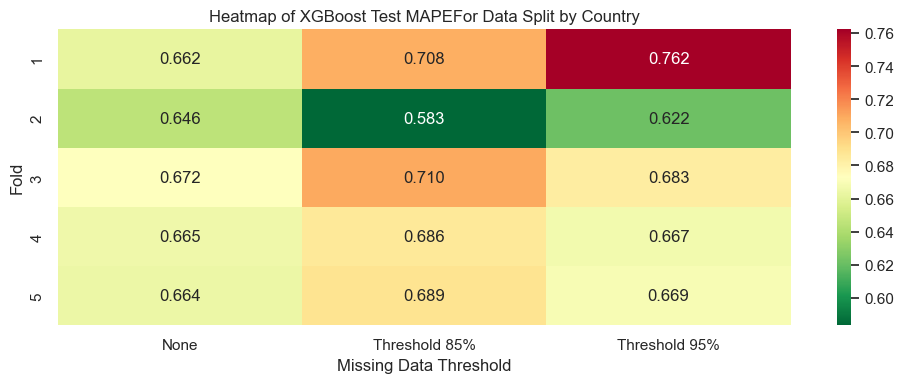

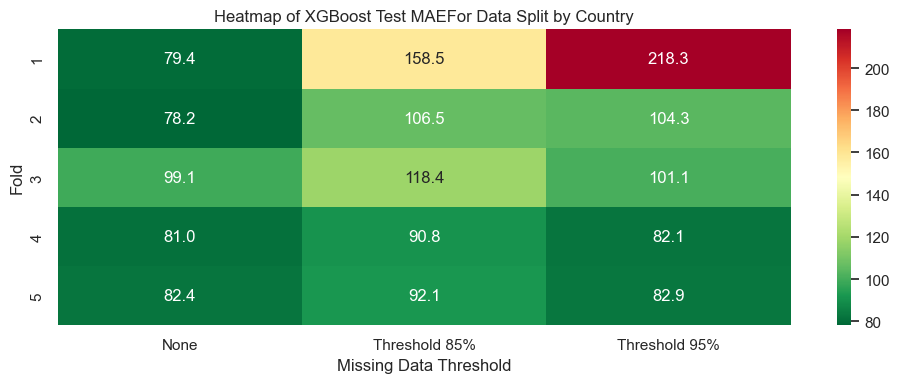

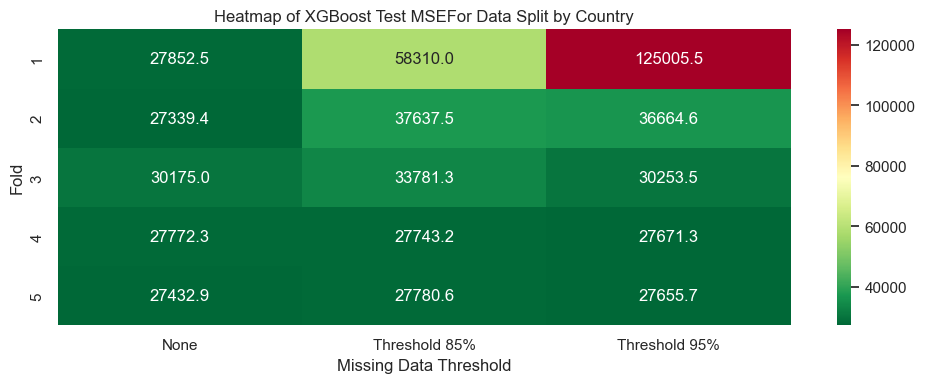

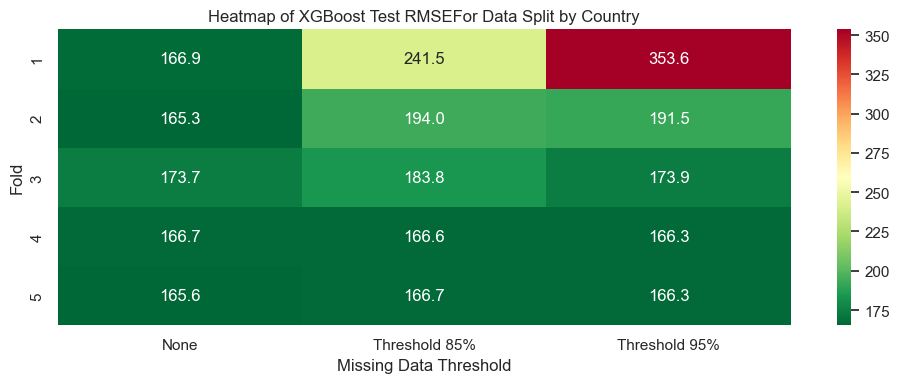

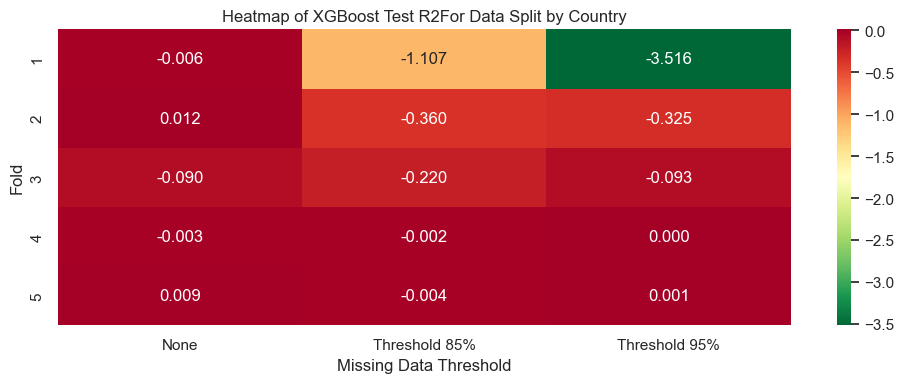

In [44]:
import seaborn as sns

data_lgbm = test_stats['XGBoost'].astype(float)

for metric in data_lgbm.columns:
    plt.figure(figsize=(10, 4))
    d = pd.DataFrame(data_lgbm[metric].unstack(level='Missing Data Threshold'))
    if metric == 'MAPE' or metric == 'R2':
        fmt = ".3f"
    else:
        fmt = ".1f"
    sns.heatmap(d, annot=True, fmt=fmt, cmap="RdYlGn_r", cbar=True)
    sns.set_theme(context='notebook', style='whitegrid')  # or 'paper'
    plt.title("Heatmap of XGBoost Test " + metric + "For Data Split by Country")
    plt.xlabel("Missing Data Threshold")
    plt.ylabel("Fold")
    plt.tight_layout()
    plt.show()

In [45]:
xgb_data = test_stats['XGBoost'].astype(float)
mean_summary_xgb = xgb_data.groupby(level='Missing Data Threshold').mean()
mean_summary_xgb = mean_summary_xgb.astype('float')
mean_summary_xgb = mean_summary_xgb.round(2)
std_summary_xgb = xgb_data.groupby(level='Missing Data Threshold').std()
std_summary_xgb = std_summary_xgb.astype('float')
std_summary_xgb = std_summary_xgb.round(2)

In [46]:
mean_corr_xgb = mean_summary_xgb.corr()
mean_corr_xgb

Evaluation Metric,MAPE,MAE,MSE,RMSE,R2
Evaluation Metric,,,,,
MAPE,1.000000,0.992465,0.815589,0.885780,-0.813433
MAE,0.992465,1.000000,0.880344,0.935973,-0.878575
MSE,0.815589,0.880344,1.000000,0.990978,-0.999993
RMSE,0.885780,0.935973,0.990978,1.000000,-0.990473
R2,-0.813433,-0.878575,-0.999993,-0.990473,1.000000


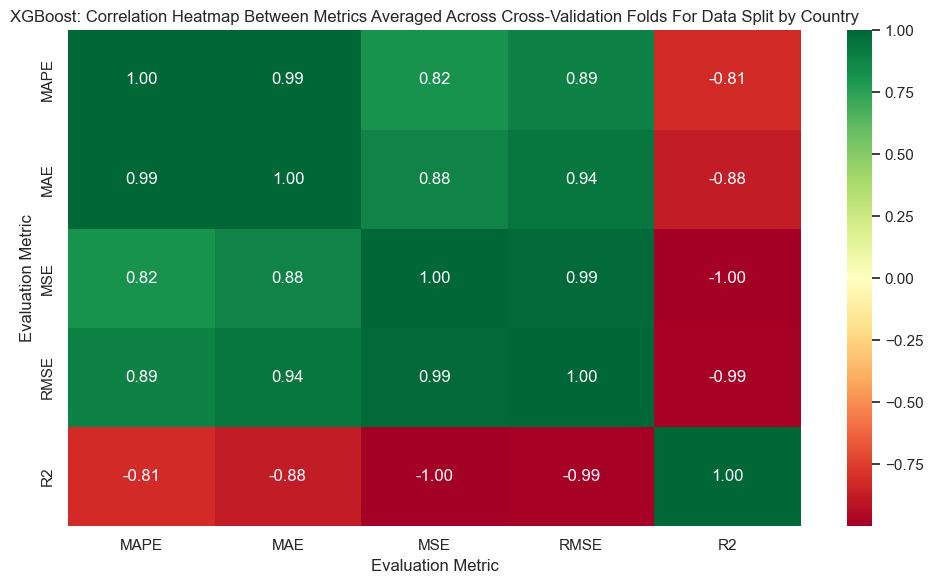

In [47]:
plt.figure(figsize=(10, 6))
sns.heatmap(mean_corr_xgb, annot=True, fmt=".2f", cmap="RdYlGn", center=0)
plt.title("XGBoost: Correlation Heatmap Between Metrics Averaged Across Cross-Validation Folds For Data Split by Country")
plt.tight_layout()
plt.show()

### Random Forest

#### Data Collection

In [48]:
rf_params = pd.DataFrame(index=index_rows, columns=['n_estimators', 'max_depth', 'min_samples_split', 
                                                     'bootstrapping', 'max_samples'])

In [49]:
testing_x_rf = testing_x.copy()
testing_x_rf['setting'] = testing_x_rf['setting'].map(countries_dict)

for fold, fold_num in enumerate(['1', '2', '3', '4', '5']):
    for thresh, thresh_name in enumerate(['Threshold 85%', 'Threshold 95%', 'None']):
        
        if thresh == 0:
            name = '85'
        elif thresh == 1:
            name = '95'
        else: name = '1'

        best_params = joblib.load(f"{output_dir}/random_forest/best_params_{fold}_{name}.pkl")
        param_list = list(best_params.values())
        rf_params.loc[(thresh_name, fold_num)] = param_list
        train_input_data = train[fold][thresh * 2].copy()
        train_input_data['setting'] = train_input_data['setting'].map(countries_dict)

        columns_needed = testing_x_rf.columns.intersection(train_input_data.columns)
        test_relevant_input = testing_x_rf[columns_needed]

        loaded_model = RandomForestRegressor(**best_params)
        train_load = loaded_model.fit(train_input_data, train[fold][thresh * 2 + 1])
        prediction = train_load.predict(test_relevant_input)
        mse = mean_squared_error(test_data_y, prediction)
        mae = mean_absolute_error(test_data_y, prediction)
        rmse = np.sqrt(mse)
        r2 = r2_score(test_data_y, prediction)

        #to calculate mape
        num_predictions = len(prediction)
        mape = 0
        for p in range(0, num_predictions):
            mape += np.abs(prediction[p] - test_data_y.iloc[p]) / np.maximum(np.abs(prediction[p]), np.abs(test_data_y.iloc[p]))
        
        mape = mape/num_predictions

        test_stats.loc[(thresh_name, fold_num), ('Random Forest', 'MSE')] = mse
        test_stats.loc[(thresh_name, fold_num), ('Random Forest', 'MAE')] = mae
        test_stats.loc[(thresh_name, fold_num), ('Random Forest', 'RMSE')] = rmse
        test_stats.loc[(thresh_name, fold_num), ('Random Forest', 'R2')] = r2
        test_stats.loc[(thresh_name, fold_num), ('Random Forest', 'MAPE')] = mape[0]
        

/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/var/folders/jd/0gmk2m5x1cl2hh0v_hsx43q40000gn/T/ipykernel_29843/1829316102.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  test_stats.loc[(thresh_name, fold_num), ('Random Forest', 'MAPE')] = mape[0]
/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/var/folders/jd/0gmk2m5x1cl2hh0v_hsx43q40000gn/T/ipykernel_29843/182

ValueError: could not broadcast input array from shape (4,) into shape (5,)

#### Visualisations

/opt/anaconda3/lib/python3.11/site-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/opt/anaconda3/lib/python3.11/site-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


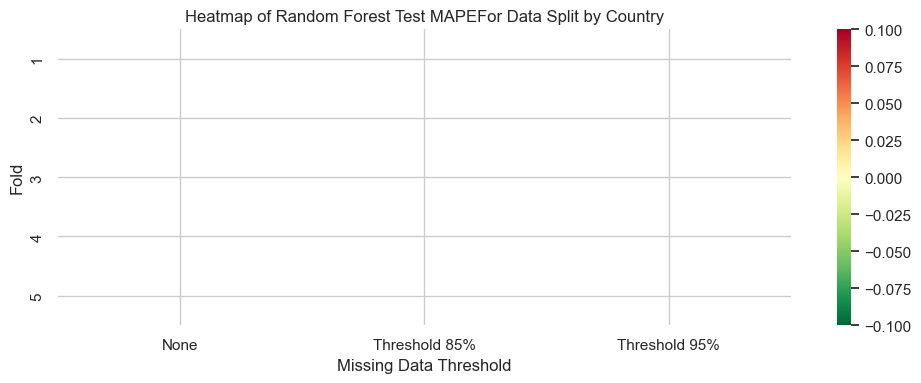

/opt/anaconda3/lib/python3.11/site-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/opt/anaconda3/lib/python3.11/site-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


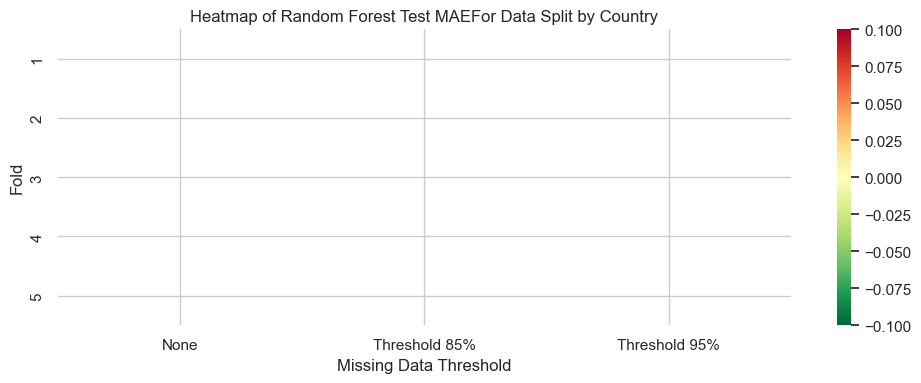

/opt/anaconda3/lib/python3.11/site-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/opt/anaconda3/lib/python3.11/site-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


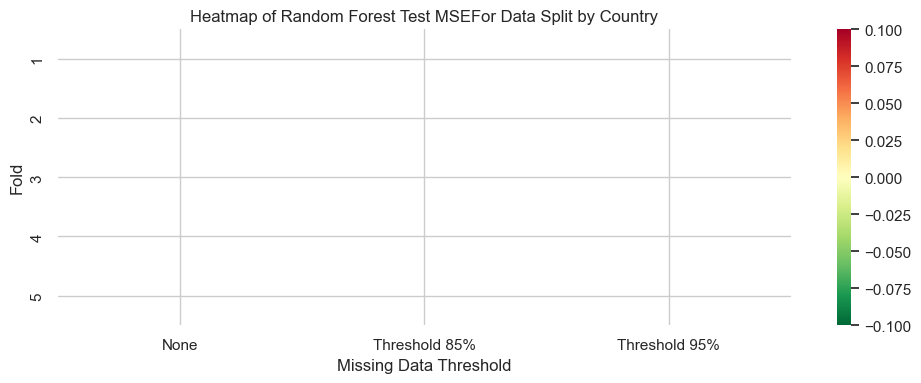

/opt/anaconda3/lib/python3.11/site-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/opt/anaconda3/lib/python3.11/site-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


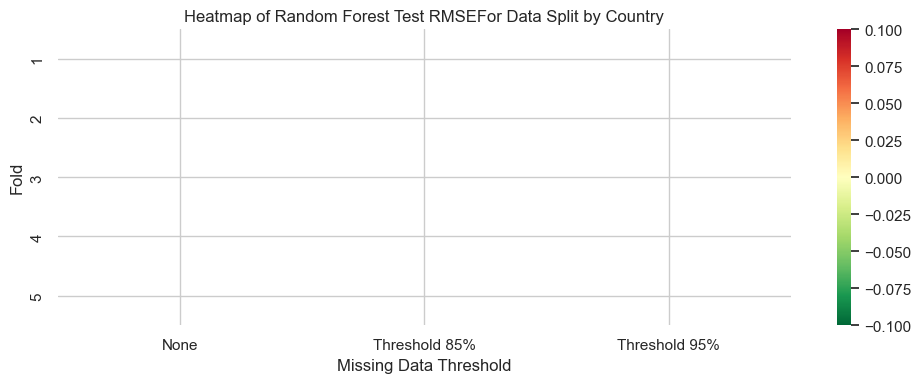

/opt/anaconda3/lib/python3.11/site-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/opt/anaconda3/lib/python3.11/site-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


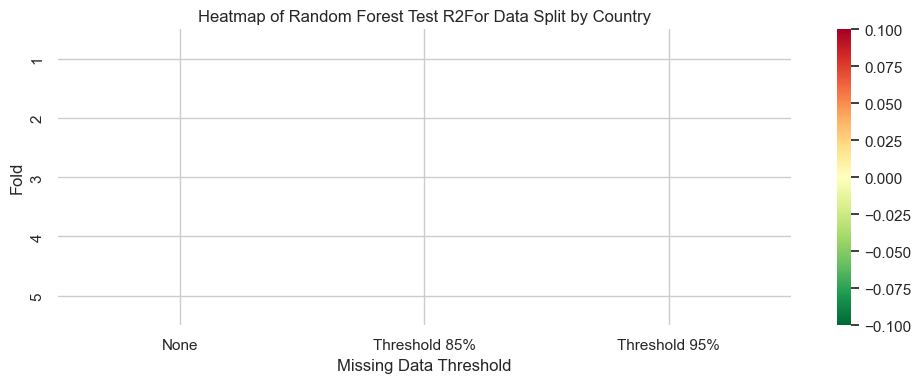

In [ ]:
import seaborn as sns

data_rf = test_stats['Random Forest'].astype(float)

for metric in data_rf.columns:
    plt.figure(figsize=(10, 4))
    d = pd.DataFrame(data_rf[metric].unstack(level='Missing Data Threshold'))
    if metric == 'MAPE' or metric == 'R2':
        fmt = ".3f"
    else:
        fmt = ".1f"
    sns.heatmap(d, annot=True, fmt=fmt, cmap="RdYlGn_r", cbar=True)
    sns.set_theme(context='notebook', style='whitegrid')  # or 'paper'
    plt.title("Heatmap of Random Forest Test " + metric + "For Data Split by Country")
    plt.xlabel("Missing Data Threshold")
    plt.ylabel("Fold")
    plt.tight_layout()
    plt.show()

In [ ]:
rf_data = test_stats['Random Forest'].astype(float)
mean_summary_rf = rf_data.groupby(level='Missing Data Threshold').mean()
mean_summary_rf = mean_summary_rf.astype('float')
mean_summary_rf = mean_summary_rf.round(2)
std_summary_rf = rf_data.groupby(level='Missing Data Threshold').std()
std_summary_rf = std_summary_rf.astype('float')
std_summary_rf = std_summary_rf.round(2)

In [ ]:
mean_corr_rf = mean_summary_rf.corr()
mean_corr_rf

Evaluation Metric,MAPE,MAE,MSE,RMSE,R2
Evaluation Metric,,,,,
MAPE,1.000000,0.994905,0.995323,0.994550,-0.994850
MAE,0.994905,1.000000,0.999991,0.999994,-1.000000
MSE,0.995323,0.999991,1.000000,0.999970,-0.999989
RMSE,0.994550,0.999994,0.999970,1.000000,-0.999996
R2,-0.994850,-1.000000,-0.999989,-0.999996,1.000000


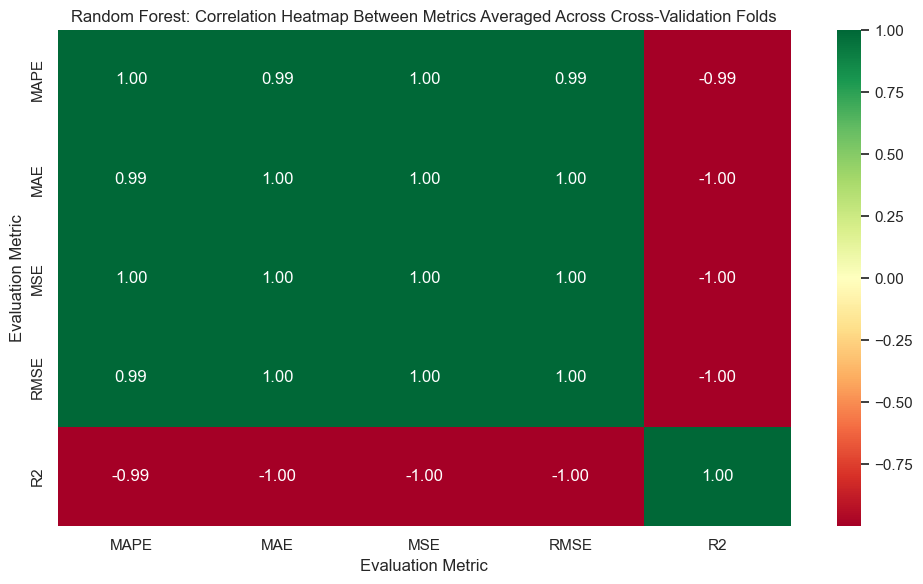

In [ ]:
plt.figure(figsize=(10, 6))
sns.heatmap(mean_corr_rf, annot=True, fmt=".2f", cmap="RdYlGn", center=0)
plt.title("Random Forest: Correlation Heatmap Between Metrics Averaged Across Cross-Validation Folds For Data Split by Country")
plt.tight_layout()
plt.show()

### Comparison Visualisations

In [ ]:
mean_concat = pd.concat([mean_summary_lgbm, mean_summary_xgb, mean_summary_rf], axis=1)
mean_concat.columns = pd.MultiIndex.from_tuples([('LightGBM', 'MAPE'), ('LightGBM', 'MAE'), ('LightGBM', 'MSE'), ('LightGBM', 'RMSE'), ('LightGBM', 'R2'), 
     ('XGBoost', 'MAPE'), ('XGBoost', 'MAE'), ('XGBoost', 'MSE'), ('XGBoost', 'RMSE'), ('XGBoost', 'R2'),
     ('Random Forest', 'MAPE'), ('Random Forest', 'MAE'), ('Random Forest', 'MSE'), ('Random Forest', 'RMSE'), ('Random Forest', 'R2')], names=['Model', 'Metric'])
mean_concat

Model                  LightGBM                              XGBoost          \
Metric                     MAPE    MAE      MSE   RMSE    R2    MAPE     MAE   
Missing Data Threshold                                                         
None                       0.47  29.64  5945.48  77.08  0.81    0.71   87.37   
Threshold 85%              0.50  31.14  7254.13  85.03  0.77    0.75  106.29   
Threshold 95%              0.40  25.50  5672.85  75.24  0.82    0.73   92.43   

Model                                          Random Forest                  \
Metric                       MSE    RMSE    R2          MAPE    MAE      MSE   
Missing Data Threshold                                                         
None                    31627.32  177.84 -0.00          0.37  26.61  5679.57   
Threshold 85%           33130.37  181.90 -0.05          0.45  32.49  8399.37   
Threshold 95%           32118.66  179.19 -0.02          0.37  27.26  5968.20   

Model                                
Metric                   RMSE    R2  
Missing Data Threshold               
None                    75.30  0.82  
Threshold 85%           91.07  0.73  
Threshold 95%           77.10  0.81

In [ ]:
std_concat = pd.concat([std_summary_lgbm, std_summary_xgb, std_summary_rf], axis=1)
std_concat.columns = pd.MultiIndex.from_tuples([('LightGBM', 'MAPE'), ('LightGBM', 'MAE'), ('LightGBM', 'MSE'), ('LightGBM', 'RMSE'), ('LightGBM', 'R2'), 
     ('XGBoost', 'MAPE'), ('XGBoost', 'MAE'), ('XGBoost', 'MSE'), ('XGBoost', 'RMSE'), ('XGBoost', 'R2'),
     ('Random Forest', 'MAPE'), ('Random Forest', 'MAE'), ('Random Forest', 'MSE'), ('Random Forest', 'RMSE'), ('Random Forest', 'R2')], names=['Model', 'Metric'])
std_concat

Model                  LightGBM                           XGBoost        \
Metric                     MAPE   MAE     MSE  RMSE    R2    MAPE   MAE   
Missing Data Threshold                                                    
None                       0.08  3.38  379.80  2.45  0.01    0.01  1.09   
Threshold 85%              0.07  4.46  916.13  5.42  0.03    0.01  9.36   
Threshold 95%              0.03  1.76  583.46  3.86  0.02    0.02  6.97   

Model                                       Random Forest                 \
Metric                      MSE  RMSE    R2          MAPE   MAE      MSE   
Missing Data Threshold                                                     
None                     246.78  0.69  0.01          0.01  1.34   525.26   
Threshold 85%           2676.50  7.17  0.08          0.04  4.13  2214.12   
Threshold 95%           1246.59  3.44  0.04          0.01  1.58   878.37   

Model                                
Metric                   RMSE    R2  
Missing Data Threshold               
None                     3.55  0.02  
Threshold 85%           11.47  0.07  
Threshold 95%            5.50  0.03

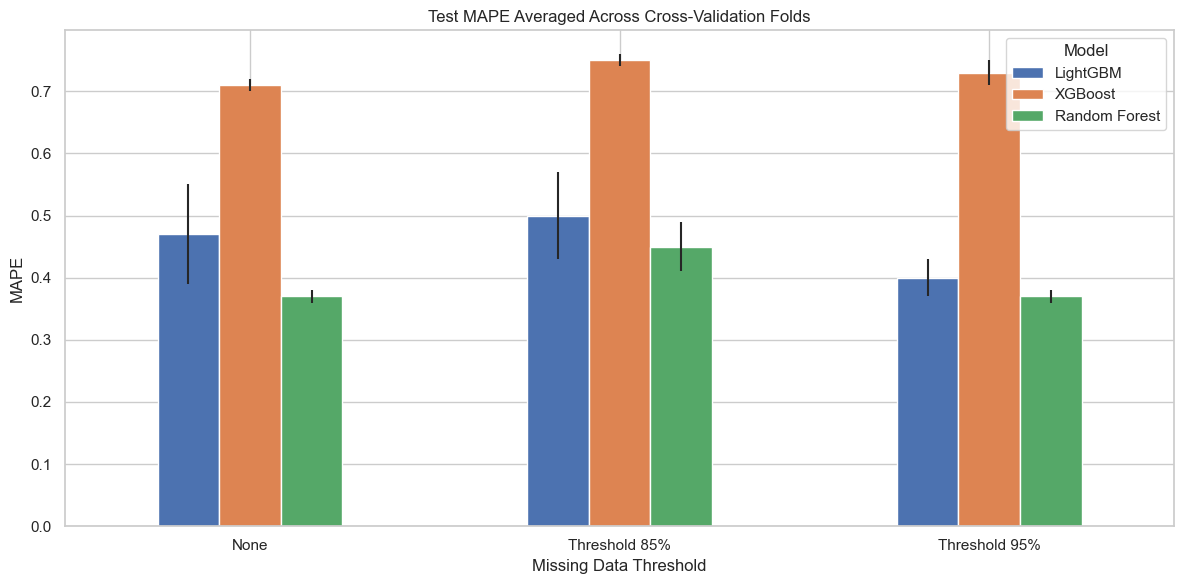

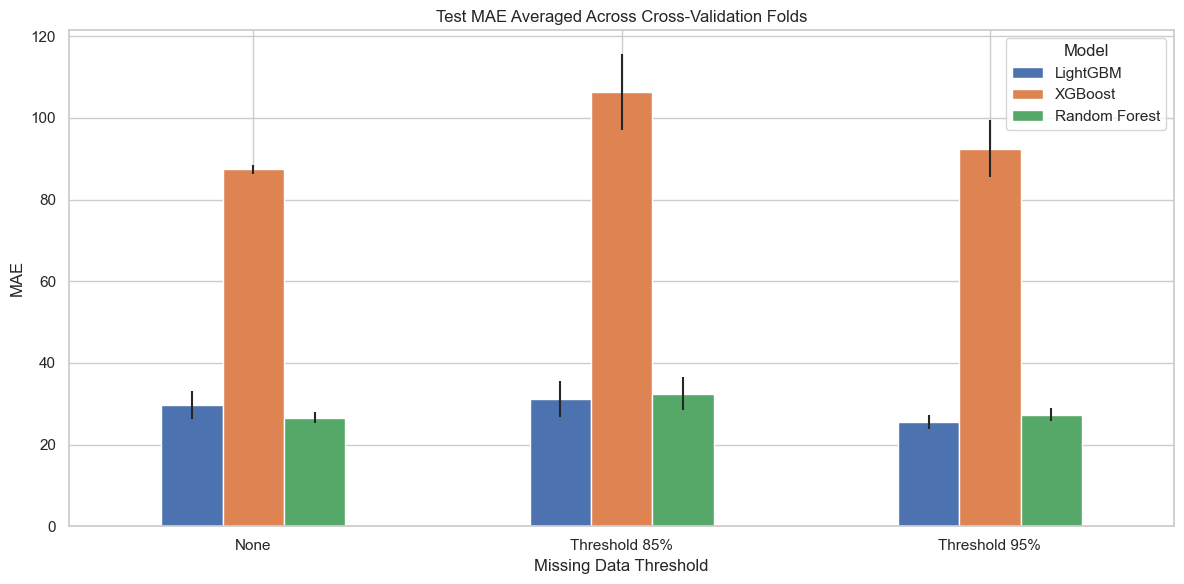

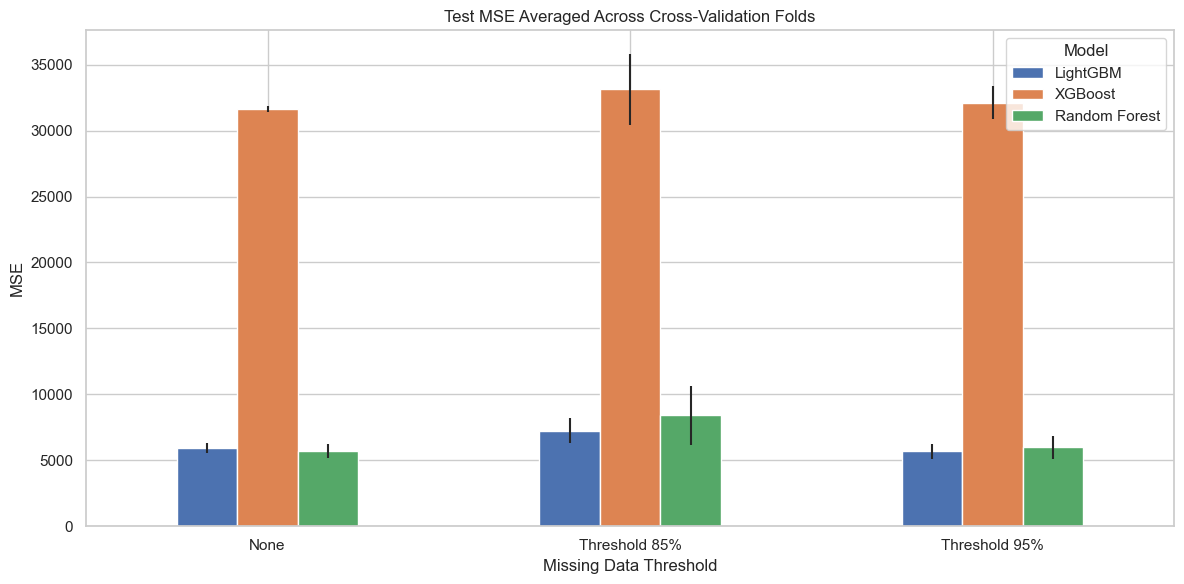

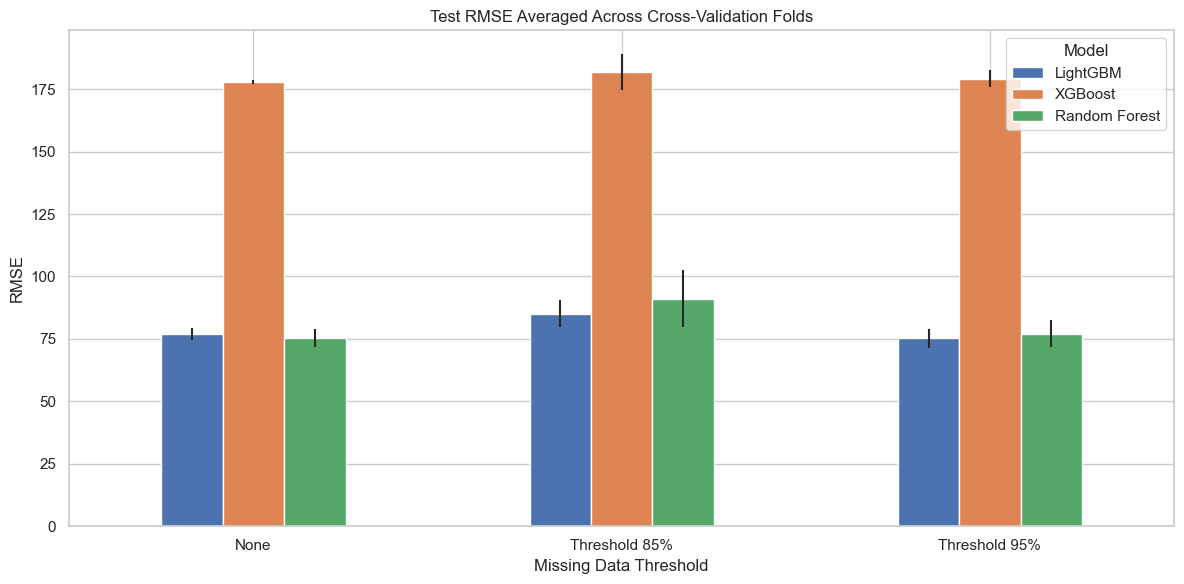

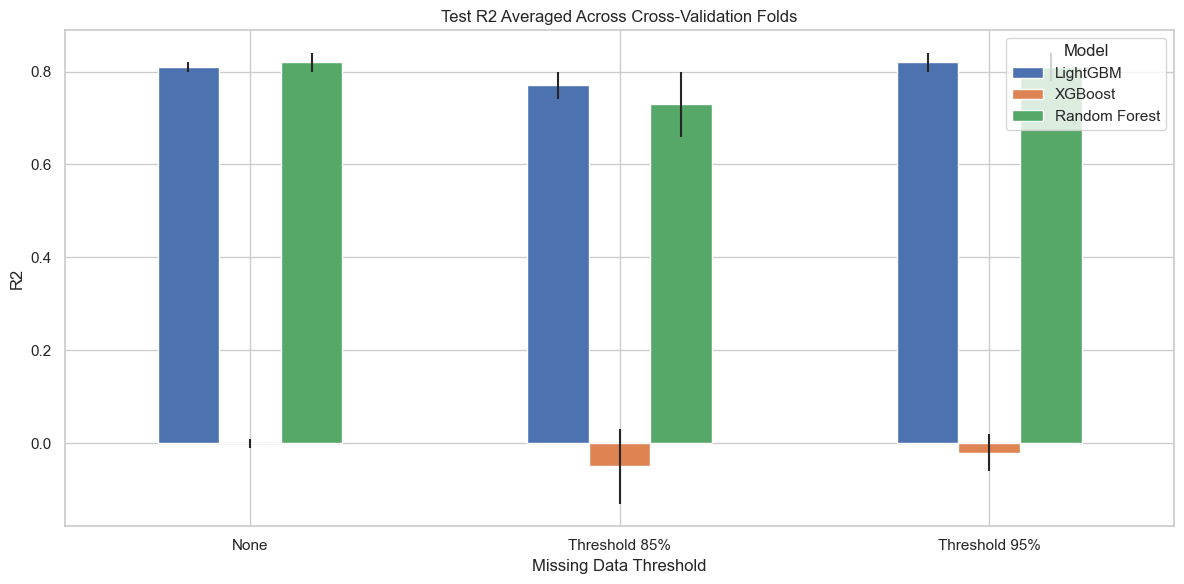

In [ ]:
mean_concat = mean_concat.astype(float)
std_concat = std_concat.astype(float)

metrics = ['MAPE', 'MAE', "MSE", 'RMSE', "R2"]
bar_index = mean_concat.index

for metric in metrics:
    data_metric = mean_concat.xs(metric, axis=1, level='Metric')
    error = std_concat.xs(metric, axis=1, level='Metric')
    ax = data_metric.plot.bar(rot=0, yerr=error, figsize=(12, 6))     
    plt.title("Test " + metric + " Averaged Across Cross-Validation Folds  For Data Split by Country")
    plt.xlabel("Missing Data Threshold")
    plt.ylabel(metric)
    plt.tight_layout()
    plt.show()